This Project uses AMALIA data for generalized Linear Models for Poverty indicators in the EU.
Thechniques used: 

- leastsquares
- logit-regression
- multinomial regression 
- poisson regression 

The Data-set is a synthetic Data-set called AMELIA (source), which aims to replicate the EU-Silc Data, but with the advantage of Open use. 

For Further Information on AMELIA:

- Data: http://amelia.uni-trier.de/?p=287
- Description: http://amelia.uni-trier.de/wp-content/uploads/2020/01/AMELIA_Data_Description_v0.2.3.1.pdf
- AMELIA-Paper: https://link.springer.com/content/pdf/10.1007/s11943-017-0214-8.pdf?pdf=button

In [1]:
setwd("C:/Users/zogaj/Bachelorarbeit/R/AMELIA_HH_level_v0.2.3")
library(dplyr)
library(magrittr)
library(DescTools)
library(dplyr)

Warning message:
"package 'dplyr' was built under R version 4.1.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'magrittr' was built under R version 4.1.3"
Warning message:
"package 'DescTools' was built under R version 4.1.3"


In [2]:
vars <- c("HID","EHHS","EDI","HY060","HY070", 
          "HS010","HS020","HS030","HS040","HS050","HS060","HH050", 
          "HS070","HS080","HS100","HS110",      
          "HY090","HY040")

####################################
############ Load the Datat ########
####################################

prefix <- "C:/Users/zogaj/Bachelorarbeit/R/AMELIA_HH_level_v0.2.3/HAML."
sufix <- "_v0.2.3.RData"

for (v in vars){
  load(paste(prefix,sufix,sep=v))
}
rm(prefix,sufix,v)

VarDesc

In [3]:
df_house <- data.frame(matrix(0, nrow = 3781289, ncol = 1))

for (v in vars){
  df_house[v] <- get(v)
}

df_house[1] <- NULL

In [4]:
head(df_house)

,HID,EHHS,EDI,HY060,HY070,HS010,HS020,HS030,HS040,HS050,HS060,HH050,HS070,HS080,HS100,HS110,HY090,HY040
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,1,1.6,611.4260,0.0000,0.00,2,2,2,2,2,2,2,1,1,1,3,237.2729,0
2,2,1.5,33888.3986,0.0000,0.00,1,1,1,1,1,1,1,1,1,1,1,229.1392,0
3,3,1.5,63275.8467,575.6191,0.00,1,1,1,1,1,1,1,1,1,1,1,418.5650,0
4,4,2.1,30314.4325,217.3636,10210.72,1,1,1,1,1,1,1,1,1,1,1,0.0000,0
5,5,2.0,-179.0461,0.0000,0.00,1,1,1,2,1,2,1,1,1,1,2,0.0000,0
6,6,1.0,17732.3175,0.0000,0.00,2,2,2,1,1,1,1,1,3,3,3,0.0000,0


In [5]:
#Dummy for every HH wich is at risk of poverty (one-hot-encoding)

poverty_border <- median(df_house$EDI) * 0.6
arp <- as.numeric(df_house$EDI <= poverty_border)
df_house["at_risk_poverty"] <- arp
arp_table <-table(arp)

the way of re-coding is desinged for **counting "depriviations"**, so that the interpretation for the regressions
becomes more "intuitive" and standardized 

- HS060: can face sudden finacial expenses; (1 if no)
- HS040: Holiday affoard; (1 if no) 
- HS010 - HS030: arrears on ... {010: Mortgage or Rent, 020: utilitybills,030: purchase instalments}; (1 if yes)
- HS050: can affoard protein Meal twice a week; (1 if no)
- HH050: keep House warm; (1 if no)

The original encoding is: *1 : yes* and *2 : no*

In [6]:
###############
# Relabel #####
#########################################################################################
# this section will change all the Factor-Variables to nummeric, for re-assinging values#
indx <- sapply(df_house, is.factor) #get colidx for each factorvariable                 #
                         #df_columns     aplly custom func to the cols; x = col         #
df_house[indx] <- lapply(df_house[indx], function(x) as.numeric(x))                     #
#########################################################################################

two_to_zero <- c("HS010", "HS020", "HS030") #arrears 2: no, 1: yes 
vec_minus_1 <- c("HS040", "HS050", "HH050", "HS060") # capacity _X_ 1:yes, 2: no

# Here the items (arrears) will change 
# so the struggle (1) stays 1 but the no struggle (2) becomes 0 
df_house[two_to_zero][df_house[two_to_zero] == 2] <-0

# Here the capacity-items (meal, housewarm, holiday, sudden expenses) (no = 2; yes = 1) 
# will be subtracted with one so the values change adequately -> no capacity (2) - 1 = 1 for struggle 
# yes,has capacity (1) - 1 = 0 for no struggle 
df_house[vec_minus_1] <- df_house[vec_minus_1] - 1

In [7]:
#############################
### Material Deprivation ####
#############################

# "Severe material deprivation rate is 
# defined as the enforced inability to pay for at least four items"
n_cant_affoard <- rowSums(cbind(as.numeric((df_house$HS070 == 2)), #cant affoard telephone
                                as.numeric((df_house$HS080 == 2)), #...TV
                                as.numeric((df_house$HS100 == 2)), #...washmachine
                                as.numeric((df_house$HS110 == 2))))#...car


#arrears of any kind; if > 0 means, that person has at least 1 arrear on ___, 
#aggregated, so it matches the 9 criteria from SILC instead of 11
arrears <- as.numeric(rowSums(cbind(df_house$HS010,df_house$HS020, df_house$HS030)) > 0)
#df_house["arrears"] <- arrears 

n_no_capacities <- rowSums(cbind(df_house$HS040, df_house$HS050,
                                 df_house$HS060, df_house$HH050))

total <- n_no_capacities + n_cant_affoard + arrears

In [8]:
t_table <- table(total)
matDep <- as.numeric(total > 3)
df_house["Material_deprivation"] <- matDep

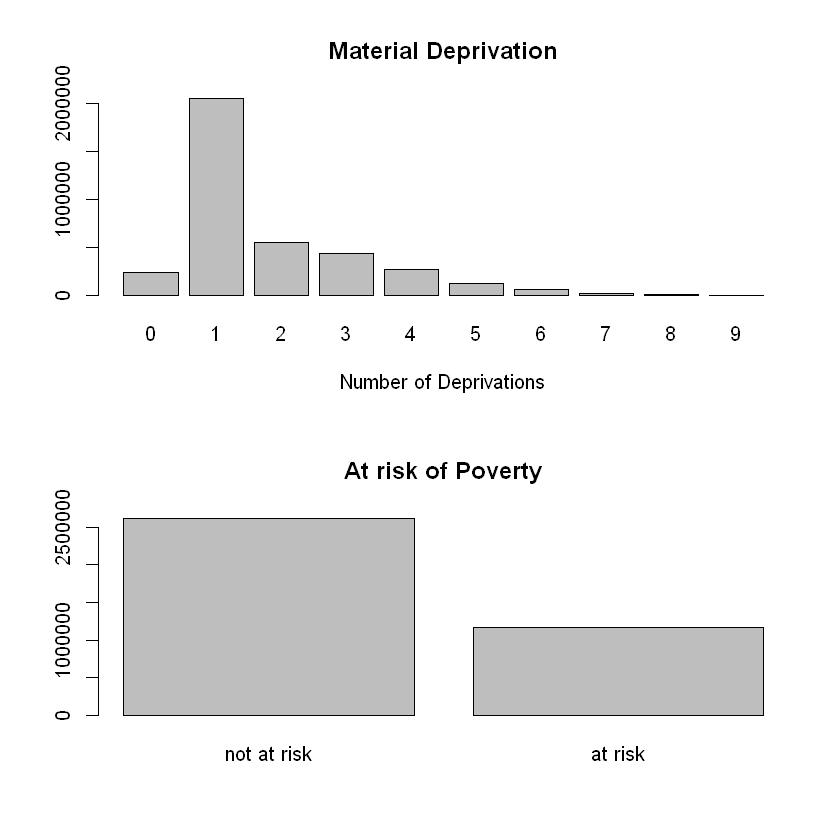

In [9]:
par(mfrow = c(2,1))
barplot(t_table, main = "Material Deprivation", xlab = "Number of Deprivations")
barplot(arp_table,names.arg = c("not at risk", "at risk"), main = "At risk of Poverty")

We have two indicators for poverty, one considers the **Households Income**, and the other one considers their **material possesions**.<br>
In the literature, it is not so clear what indicator shoul be used, so a combined approach is recommended. We take both binary-Variables and put them into a *Contingency-table*.  


In [10]:
poverty_lvl <- table(arp, matDep)
rownames(poverty_lvl) <- c("no poverty risk", "at poverty risk")
colnames(poverty_lvl) <- c("not deprived", "deprived")
poverty_lvl

                 matDep
arp               not deprived deprived
  no poverty risk      2520465    93623
  at poverty risk       763941   403260

From this we will create a third Variabl **povCat**. 
- 1: not deprived and not at risk of poverty
- 2: not deprived but at risk of poverty
- 3: deprived but not at risk of poverty
- 4: not deprived and not at risk of poverty

In [11]:
# Generate categories 
# at_risk_poverty   | Material_deprivation
cat1 <- as.numeric(with(df_house, at_risk_poverty == 0 & Material_deprivation == 0))
cat2 <- as.numeric(with(df_house, at_risk_poverty == 1 & Material_deprivation == 0)) * 2 
cat3 <- as.numeric(with(df_house, at_risk_poverty == 0 & Material_deprivation == 1))* 3
cat4 <- as.numeric(with(df_house, at_risk_poverty == 1 & Material_deprivation == 1))* 4
povCat <- rowSums(cbind(cat1,cat2,cat3,cat4))
table(povCat)

povCat
      1       2       3       4 
2520465  763941   93623  403260 

In [12]:
EHHS <- df_house$EHHS
EDI <- df_house$EDI
n_dep <- total

##################
### Save Frame ########################################################################
y_frame <- as.data.frame(cbind(povCat, matDep, arp, EHHS, EDI, n_dep))#################
save(y_frame, file = "C:/Users/zogaj/Bachelorarbeit/R/y_frame.RData")##################
#######################################################################################
rm(list = ls()[!ls() %in% "y_frame"])

So far we have only dealt with data on the **Household-lvl**. However there is also data available, which concerns about the **personal-lvl** of each Individual, within the household. We take this Information and aggregate it on the Household lvl via *HID-matching.*  

In [13]:
#AMELIA_P_level_v0.2.3
setwd("C:/Users/zogaj/Bachelorarbeit/R/AMELIA_P_level_v0.2.3")

vars <- c("PID","HID","AGE","BAS","SEX","ISCED","MST","HHS","PWHI","INC","SOC", 
          "PL070","PL072","PL090","PL085")

# PL070: number of months spent at fulltimeWork
# PL072: number of months spent at parttimeWork
# PL085: Number of Months in retirement
# PL087: Number of Months spent Studying
# PL090: Number of Months spent in inactivity
# PL087: Number of Months spent Studying
# PL080: Number of Months spent in unemployment

# PWHI: Person with highest income in Household
# SEM: Selfemployed
# PY090: uemp. Benefits
# BAS: Basic activity; at Work, unemp,...
# MST: Marital Status

prefix <- "C:/Users/zogaj/Bachelorarbeit/R/AMELIA_P_level_v0.2.3/PAML."
sufix <- "_v0.2.3.RData"


for (v in vars){
  load(paste(prefix,sufix,sep=v))
}
rm(prefix,sufix,v)

In [14]:
##################################
####### Make DataFrame ###########
##################################

df_pers <- data.frame(matrix(0, nrow = 10012600, ncol = 1))

#Fill empty Frame
for (v in vars){
  df_pers[v] <- get(v)
}
df_pers[1] <- NULL 
rm(list=setdiff(ls(), "df_pers"))

In [15]:
head(df_pers)

,PID,HID,AGE,BAS,SEX,ISCED,MST,HHS,PWHI,INC,SOC,PL070,PL072,PL090,PL085
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,101,1,54,4,1,3,1,3,1,0.00,0.0000,0,0,12,0
2,102,1,8,4,1,NA,1,3,2,0.00,0.0000,NA,NA,NA,NA
3,103,1,6,4,2,NA,1,3,2,0.00,0.0000,NA,NA,NA,NA
4,201,2,36,1,1,5,2,2,1,36608.27,120.2737,12,0,0,0
5,202,2,37,4,2,4,5,2,2,15692.09,15692.0888,0,0,0,0
6,301,3,61,1,1,2,2,2,1,59044.59,106.5939,12,0,0,0


In [16]:
### Female Highest Earner ### 
# filter all females who earn the most and select their HID 
XX <- df_pers %>% filter(SEX == 2 & PWHI == 1) %>% select(HID) 
# filter all males who earn the most and select their HID 
XY <- df_pers %>% filter(SEX == 1 & PWHI == 1) %>% select(HID)

In [17]:
XX <- cbind(XX,rep(1,length(XX$HID))) # sets value for female
XY <- cbind(XY,rep(0,length(XY$HID))) # sets value for male 
names(XX)[2] <- "sex"
names(XY)[2] <- "sex"

unsorted <- rbind(XX, XY) # stacks on top
sex_of_head <- unsorted[order(unsorted$HID),] #sorts by HID for right order
sex_of_head$HID <- NULL 
rm(XX,XY, unsorted)
head(sex_of_head)
#in the 1-st Household, the highest earner is male, in the 5-th, it's female etc...

,sex
,<dbl>
1790084,0
1790085,0
1790086,0
1790087,0
1,1
2,1


In [18]:
educ_of_head <- df_pers %>% filter(PWHI == 1) %>% select(ISCED) #Education

age_of_head <- df_pers %>% filter(PWHI == 1) %>% select(AGE) #Age

MST_of_head <- df_pers %>% filter(PWHI == 1) %>% select(MST) #Maritial Status 

In [19]:
# Count all people in fulltime-work, for each Household
n_people_in_work <- tapply(df_pers$BAS, df_pers$HID, function(x) sum(x == 1))

In [20]:
#PL070: n months in fulltime
#PL072: n months in parttime

sub <- df_pers[,c(1,2,3,12,13)]
head(sub)
sub$PL072 <- sub$PL072 * 0.5  # weight the months: 1 year of halftime work == 6 months of fulltime work 

# Ignore evryone above "working Age": Not Uniform across Europe tho ...
sub["PL070"][sub$AGE >= 64, ] <- NA
sub["PL072"][sub$AGE >= 64, ] <- NA
 

sub["work"] <- rowSums(sub[,c(4,5)]) #combine their (weighted) total work 
work_intensity <- tapply(sub$work, sub$HID, 
                         function(x) sum(na.omit(x))/(12*length(na.omit(x)))) 
                         # length(na.omit(x)): number of people, that couldve worked that year (i.e. 16 <= AGE < 64)
                         # multiply by 12, to get pontential working months of the household 
                         # sum(na.omit(x)): sum of the (weighted) Months actually worked 
                         # output: number between 0 and 1: 1 if every person of the Household worked fulltime the entire year 

,PID,HID,AGE,PL070,PL072
,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,101,1,54,0,0
2,102,1,8,NA,NA
3,103,1,6,NA,NA
4,201,2,36,12,0
5,202,2,37,0,0
6,301,3,61,12,0


In [21]:
##################
### Save Frame ########################################################################
x_frame <- as.data.frame(cbind(sex_of_head, educ_of_head,##############################
                               MST_of_head, n_people_in_work, work_intensity))#########
save(x_frame, file = "C:/Users/zogaj/Bachelorarbeit/R/x_frame.RData")##################
#######################################################################################
rm(list = ls()[!ls() %in% "x_frame"])

Combine both Dataframes and take a 1% sample of the overall population. 

In [25]:
setwd("C:/Users/zogaj/Bachelorarbeit/R")
load("y_frame.RData")
load("x_frame.RData")

df <- cbind(y_frame, x_frame)


sample_size <- round(length(df[,1]) * 0.01, 0) # 1 % samplesize 

set.seed(123)
df <- df[sample(nrow(df), sample_size), ]

str(df)
df$povCat <- as.factor(df$povCat)
df$ISCED <- as.factor(df$ISCED)
df$arp <- as.factor(df$arp)
df$matDep <- as.factor(df$matDep)
df$sex <- as.factor(df$sex) # male = 0 --> reference; female = 1
df$n_people_in_work <- as.numeric(df$n_people_in_work)
rm(x_frame, y_frame)
head(df)

'data.frame':	37813 obs. of  11 variables:
 $ povCat          : num  1 1 1 4 4 1 1 1 1 1 ...
 $ matDep          : num  0 0 0 1 1 0 0 0 0 0 ...
 $ arp             : num  0 0 0 1 1 0 0 0 0 0 ...
 $ EHHS            : num  2.1 2.5 2.1 1 1 1 2.3 1.5 1.5 2 ...
 $ EDI             : num  26425 21627 19914 6844 343 ...
 $ n_dep           : num  1 1 2 4 6 1 1 3 1 1 ...
 $ sex             : num  1 1 1 1 1 1 0 0 0 0 ...
 $ ISCED           : num  3 5 5 3 3 3 3 2 3 3 ...
 $ MST             : num  2 2 2 5 1 2 2 1 1 2 ...
 $ n_people_in_work: int  1 3 1 0 0 1 1 2 2 2 ...
 $ work_intensity  : num  0.5 0.667 0.5 0 NaN ...


,povCat,matDep,arp,EHHS,EDI,n_dep,sex,ISCED,MST,n_people_in_work,work_intensity
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
953992,1,0,0,2.1,26425.256,1,1,3,2,1,0.5000000
1578610,1,0,0,2.5,21627.100,1,1,5,2,3,0.6666667
62355,1,0,0,2.1,19914.181,2,1,5,2,1,0.5000000
1547518,4,1,1,1.0,6844.375,4,1,3,5,0,0.0000000
1317635,4,1,1,1.0,343.424,6,1,3,1,0,NaN
1596220,1,0,0,1.0,38475.244,1,1,3,2,1,1.0000000


From Here the actuall analysis of the Data beginns. We want to identify factors, that increase the Risk of a Household beeing poor. 
For that we can take following independt Variables: 

- EHHS: Equivlized household size
- sex : 1 if female leads the Household; 0 if male 
- MST: Maritial Status of Household-head
- n_people_at_work
- work_intensity: percentage of total work done / all work "possible" 
- ISCED: Education of Household-head by ISCED standards 

Multiple Regressiontechniques (GLM) are possible:

- OLS: EDI (Equialized disposable Income) ~ **X**
- Logit: arp (at risk of poverty) or matDep (materialy Deprived) ~ **X**
- multinomial: povCat (poverty Category) ~ **X**
- poisson: n_dep (number of deprivations) ~ **X**
